In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



# Drawing Polygons and Lines on images

In [2]:



# Create a black image
img = np.zeros((512,512,3), np.uint8)


# Draw a diagonal blue line with thickness of 5 px
cv2.line(img,(40,0),(511,511),(255,0,0),5)

# Note that the drawing functions actually alters the image. To refresh, you need to recall the frame or image again

cv2.imshow('image',img)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Read Depth Camera

In [2]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, n_resize):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/n_resize), int(frame_width/n_resize)))
    
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/n_resize), int(frame_height/n_resize)),\
                                    interpolation = cv2.INTER_AREA)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    cv2.destroyAllWindows()
    return depth_frames

In [3]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

    return

In [4]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [5]:

n_test = 35
date = '11_25_2020'
test_str = r'\test' + str(n_test)
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V5\Test_Subject_leo" + test_str

train_dcamera_path = data_dir + r'\depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
n_resize = 1
x_train = read_depth_camera(train_dcamera_path, show_video, n_resize)


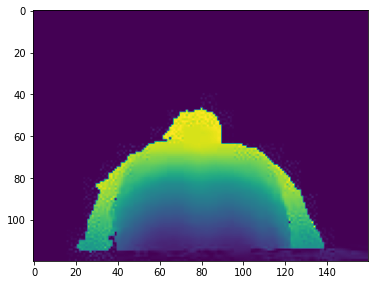

In [12]:
show_frame(x_train, [1000])

# Read Output Data


In [9]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [85]:
test_str = r'\test' + str(n_test)
date = '11_25_2020'
data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V5\Test_Subject_leo" + test_str
qtm_file_data_dir = data_dir + r'\qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
show_qtm_plot = True
theta_interest = 'z'
y_train = read_output_data(qtm_file_data_dir,theta_interest).values
theta_x = read_output_data(qtm_file_data_dir,'x').values
theta_y = read_output_data(qtm_file_data_dir,'y').values
theta_z = read_output_data(qtm_file_data_dir,'z').values

# Find Regions of Interest (ROI)

In [11]:
def obtain_pixels_roi(frame, pts):
    # create mask with zeros
    mask = np.zeros((frame.shape), dtype = np.uint8)
    # Apply mask using pts
    cv2.fillPoly(mask, [pts], (255,255,255))
    
    # get color values 
    values = frame[np.where((mask == 255))]
    
    return(values)

In [12]:
def define_roi(frame, theta_x, theta_y, show_fig):
    # all units are in pixels
    
    # height of C7 in y-axis
    c7_h = 55
    
    # multiplying factors for computing shifts and tilting of spine and shoulder lines
    amp_y = 0.95
    offset_y = 45
    amp_x = 0.9
    
    # center of person in neutral position in x-axis
    sit_center_x_n = 80
    
    # y-position of center of person's butt is always at the bottom of image 
    sit_center_y = frame.shape[0]
    
    # x-position of center of person's butt changes as the person leans left and right
    sit_center_x = int(sit_center_x_n - amp_x * sit_center_x_n * math.sin(theta_x * math.pi/180))
    
    # x-position of the spinal line changes as the person leans left and right
    spine_x = int(-c7_h * math.sin(amp_x * theta_x * math.pi/180) + sit_center_x)
    
    # y-position of the spinal line extends to the top of the image
    spine_y = 0
    
    # shoulder width
    shoulder_w = 40
    
    # left shoulder zone top left (tl) point coordinates
    shld_l_tl_x = spine_x - shoulder_w
    shld_l_tl_y = 0
    
    # left shoulder zone bottom left (bl) point coordinates
    shld_l_bl_x = sit_center_x - shoulder_w
    shld_l_bl_y = sit_center_y
    
    # right shoulder zone top right (tr) point coordinates
    shld_r_tr_x = spine_x + shoulder_w
    shld_r_tr_y = 0
    
    # right shoulder zone bottom right (br) point coordinates
    shld_r_br_x = sit_center_x + shoulder_w
    shld_r_br_y = sit_center_y
    
    
    # define points for left shoulder zone
    pts_l = np.array([[shld_l_tl_x, shld_l_tl_y], [shld_l_bl_x, shld_l_bl_y], [sit_center_x, sit_center_y], [spine_x, spine_y]])
    pts_l = pts_l.reshape((-1,1,2))
    
    
    # define points for right shoulder zone
    pts_r = np.array([[shld_r_tr_x, shld_r_tr_y], [shld_r_br_x, shld_r_br_y], [sit_center_x, sit_center_y], [spine_x, spine_y]])
    pts_r = pts_r.reshape((-1,1,2))
    
    if show_fig == True:
        # Draw the shoulder zones
        cv2.polylines(frame, [pts_l], True, (255,255,255)) # left zone
        cv2.polylines(frame, [pts_r], True, (255,255,255)) # right zone

        # Plot
        plt.figure(figsize = (4,4))
        plt.imshow(frame, cmap = 'gray', interpolation = 'bicubic')
        plt.show()

    # Obtain pixel values within each shoulder zone
    pxs_l = obtain_pixels_roi(frame, pts_l)
    pxs_r = obtain_pixels_roi(frame, pts_r)
    
    

    
    return (pxs_l, pxs_r)

# Calculate Angle of Upper Torso

In [86]:
# x_train = read_depth_camera(train_dcamera_path, show_video, n_resize)
j = 0
frame = x_train[j]

pxs_l, pxs_r = define_roi(frame, theta_x[j], theta_y[j], show_fig = False)

framecopy = np.uint8(frame)
edges = cv2.Canny(framecopy, 100, 200)
# sobelx = cv2.Sobel(edges, cv2.CV_64F, 1, 0)
# sobely = cv2.Sobel(edges, cv2.CV_64F, 0, 1)

# angles = np.zeros((sobelx.shape))
# cv2.phase(sobelx, sobely, angle = angles, angleInDegrees = True)

plt.imshow(edges)
# plt.figure(figsize = (5,5))
# plt.imshow(sobelx, cmap = 'gray')

# plt.figure(figsize = (5,5))
# plt.imshow(sobely, cmap = 'gray')

# Compute $\Delta{\overline{d}}$ from Regions of Interest (ROI)

In [87]:
x_train = read_depth_camera(train_dcamera_path, show_video, n_resize)
diff_dis = np.empty((len(x_train),1))
mean_l = np.empty((len(x_train),1))
mean_r = np.empty((len(x_train),1))
std_l = np.empty((len(x_train),1))
std_r = np.empty((len(x_train),1))

# for j in [1, 3500]:
for j in range(len(x_train)):    
    pxs_l, pxs_r = define_roi(x_train[j], theta_x[j], theta_y[j], show_fig = False)
    pxs_l[pxs_l == 0] = np.nan
    pxs_r[pxs_r == 0] = np.nan
    mean_l[j] = np.nanmean(pxs_l)
    mean_r[j] = np.nanmean(pxs_r)
    std_l[j] = np.nanstd(pxs_l)
    std_r[j] = np.nanstd(pxs_r)
    diff_dis[j] = np.nanmean(pxs_l) - np.nanmean(pxs_r)
#     print(diff_dis[j])


diff_dis = np.nan_to_num(diff_dis)
mean_l = np.nan_to_num(mean_l)
mean_r = np.nan_to_num(mean_r)
std_l = np.nan_to_num(std_l)
std_r = np.nan_to_num(std_r)

C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [89]:
%matplotlib qt
# Plot the results 
data_i = np.linspace(0, len(x_train), len(x_train))
plt.figure(figsize = (15,5))
plt.plot(data_i, diff_dis)
plt.plot(data_i, theta_z)


# Regress $\Delta{\overline{d}}$ to $\theta_z$ using Polynomial Regression

In [18]:
# Define index of interest
c = 8 # time_offset
i_start = 1
i_end = len(theta_z)-c

# i_start = 3525
# i_end = 3678


# i_start = 1
# i_end = 5500

# Define X and Y
X = diff_dis[i_start:i_end,0]
Y = theta_z[i_start+c:i_end+c,0]

# Polynomial Regression
z = np.polyfit(X,Y,2)
p = np.poly1d(z)


# Predict
Y_pred = p(X)


In [19]:
# Plot the prediction and true
plt.figure(figsize = (5,5))
data_i = np.linspace(0,(i_end - i_start), (i_end - i_start ))

a1 = plt.plot(data_i, Y_pred, 'k-')
a2 =  plt.plot(data_i, Y, 'r-')
# a3 = plt.plot(data_i, X,'b-')

plt.ylabel('twist angle(deg)')
plt.xlabel('data index')
plt.legend(['pred','true'])

# Regress $\Delta{\overline{d}}$ to $\theta_z$ using Linear Regression

In [20]:
# Define index of interest
c = 8 # time_offset
# i_start = 1
# i_end = len(theta_z)-c

# i_start = 3525
# i_end = 3678

i_start = 1
i_end = 5500


# Regress X and Y 

X = diff_dis[i_start:i_end,0]
Y = theta_z[i_start + c:i_end + c,0]

slope, intercept, r_value, p_value,std_error = stats.linregress(X, Y)


print('slope and intercepts:', str(slope), ', ', str(intercept))
print('r-value:', str(r_value))



slope and intercepts: 0.5771287165029068 ,  -2.42597162411396
r-value: 0.7687402854354931


In [21]:
# plotting zone of interest
data_i = np.linspace(0,(i_end - i_start), (i_end - i_start ))
plt.figure(figsize = (15,5))
plt.plot(data_i, X)
plt.plot(data_i, Y)


In [22]:
# Plot the raw data and correlation
plt.figure(figsize = (5,5))
plt.plot(X, Y, 'o', label='original data')
plt.plot(X, intercept + slope*X, 'r', label='fitted line')
plt.legend()
plt.show()



In [23]:
# Plot the prediction and true
plt.figure(figsize = (5,5))
data_i = np.linspace(0,(i_end - i_start), (i_end - i_start ))

a1 = plt.plot(data_i, Y, 'k-')
a2 =  plt.plot(data_i, intercept + slope * X, 'r-')
# a3 = plt.plot(data_i, X,'b-')

plt.ylabel('twist angle(deg)')
plt.xlabel('data index')
plt.legend(['true','pred', 'raw'])
plt.grid(which='both')

# Observations
The regression works well when the person is in neutral position. The next best scenarios occur when the person is leaning forward/backward or left/right. The worst case scenario is when the person is leaning front and sideways (because the depth doesn't change as much due to the field of view. You only see the contours of the shoulders moving).

Thus, we should somehow get a metric for the contour as well. 

Or we can try multivariate regression using theta_x and theta_y, so that they can somehow amplify the diff_dis term

# Regress $\Delta{\overline{d}}$ to $\theta_z$ using Multivariate Linear Regression

In [24]:
# Define index of interest
c = 8 # time_offset
i_start = 1
i_end = len(theta_z)-c

# i_start = 3525
# i_end = 3678


# X = np.hstack((mean_l[i_start:i_end,:], mean_r[i_start:i_end,:])) #, theta_x[i_start:i_end,:], theta_y[i_start:i_end,:])) #, diff_dis[i_start:i_end,:]))
# X = np.hstack((diff_dis[i_start:i_end,:], theta_x[i_start:i_end,:], theta_y[i_start:i_end,:]))
X = np.hstack((mean_l[i_start:i_end,:], mean_r[i_start:i_end,:],  mean_l[i_start:i_end,:] * theta_x[i_start:i_end,:], mean_r[i_start:i_end,:] * theta_x[i_start:i_end,:]))
Y = np.array(theta_z[i_start:i_end,:])


In [25]:
# Regress
linear_regression = LinearRegression(fit_intercept = True)#copy_X = True, fit_intercept = True, normalize = True)
linear_regression.fit(X,Y)

# predict
Y_pred = linear_regression.predict(X)

In [26]:
# plot
plt.figure(figsize = (5,5))
data_i = np.linspace(0,(i_end - i_start), (i_end - i_start ))

a1 = plt.plot(data_i, Y, 'k-')
a2 =  plt.plot(data_i, Y_pred, 'r-')

plt.ylabel('twist angle(deg)')
plt.xlabel('data index')
plt.legend(['true','pred',])

# Regress using SVR 

In [27]:
def standardize(data):
    
    z = data - np.mean(data) / np.std(data)


    return(z)

In [95]:
# Obtain X and Y data
c = 8
# i_start = 3525
# i_end = 3678 - c


i_start = 1
i_end = len(x_train)

X = np.array([standardize(theta_x[i_start:i_end,0]), standardize(theta_y[i_start:i_end,0]), standardize(diff_dis[i_start:i_end,0])]).transpose()
Y = standardize(theta_z[i_start+c:i_end+c,0])


In [29]:
# Fit SVR to the dataset
regressor = SVR(kernel = 'rbf',C = 10)
regressor.fit(X, Y)

SVR(C=10)

In [30]:
y_pred = regressor.predict(X)
y_new = Y
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r-')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 1')
plt.ylabel('Angle (degrees))')
plt.show()

# Regress using Neural Network

In [96]:
# Obtain X and Y data
c = 8
i_start = 3525
i_end = 3678 - c

i_start = 2300
i_end = 5050 - c

i_start = 1
i_end = len(x_train) - c

# X = np.array([standardize(theta_x[i_start:i_end,0]), standardize(theta_y[i_start:i_end,0]), standardize(diff_dis[i_start:i_end,0])]).transpose()
# X = np.hstack((mean_l[i_start:i_end,:], mean_r[i_start:i_end,:],\
#                theta_x[i_start:i_end,:],  theta_y[i_start:i_end,:],\
#                std_l[i_start:i_end,:], std_r[i_start:i_end,:]))

X = np.hstack((mean_l[i_start:i_end,:], mean_r[i_start:i_end,:]))
               
               
               
# X = np.hstack((mean_l[i_start:i_end,:], mean_r[i_start:i_end,:],\
#                std_l[i_start:i_end,:], std_r[i_start:i_end,:]))


Y = standardize(theta_z[i_start+c:i_end+c,0])


In [52]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [67]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"


In [62]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='mae', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [59]:
def compile_and_fit(X,Y, model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
        
    model.compile(optimizer=optimizer,
                loss = 'mae',
                metrics=['mae'])

    model.summary()

    history = model.fit(
        X, Y,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split = 0.2,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [109]:
FEATURES = 2
# N_VALIDATION = len()
N_TRAIN = len(X)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN

In [114]:
# Create Neural Netowrk
dropout_rate = 0.2
tiny_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_shape = (FEATURES, )),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation = 'linear')
])
    
tiny_model.compile(optimizer = 'adam',
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss = 'mae',
    metrics = ['mae'])

In [115]:
tiny_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 200)               600       
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [68]:
size_histories = {}
size_histories['Tiny_leo'] = compile_and_fit(X, Y, tiny_model, 'sizes/Tiny_leo')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:5.5908,  mae:5.5908,  val_loss:4.8216,  val_mae:4.8216,  
....................................................................................................
Epoch: 100, loss:4.4014,  mae:4.4014,  val_loss:4.7996,  val_mae:4.7996,  
....................................................................................................
Epoch: 200, loss:4.3210,  mae:4.3210,  val_loss:4.8472,  val_mae:4.8472,  
..............................................................................................

KeyboardInterrupt: 

In [ ]:

history = tiny_model.fit(X, Y, batch_size = 50, epochs = 100, validation_split = 0.2)


Epoch 1/100
449/449 [==============================] - 1s 2ms/step - loss: 9.0813 - mae: 9.0813 - val_loss: 11.7720 - val_mae: 11.7720
Epoch 2/100
449/449 [==============================] - 1s 2ms/step - loss: 8.2316 - mae: 8.2316 - val_loss: 11.8344 - val_mae: 11.8344
Epoch 3/100
449/449 [==============================] - 1s 2ms/step - loss: 8.2699 - mae: 8.2699 - val_loss: 11.6688 - val_mae: 11.6688
Epoch 4/100
449/449 [==============================] - 1s 2ms/step - loss: 8.0060 - mae: 8.0060 - val_loss: 12.1861 - val_mae: 12.1861
Epoch 5/100
449/449 [==============================] - 1s 2ms/step - loss: 8.0982 - mae: 8.0982 - val_loss: 12.7227 - val_mae: 12.7227
Epoch 6/100
449/449 [==============================] - 1s 2ms/step - loss: 7.9883 - mae: 7.9883 - val_loss: 13.3882 - val_mae: 13.3882
Epoch 7/100
449/449 [==============================] - 1s 2ms/step - loss: 8.0376 - mae: 8.0376 - val_loss: 13.8727 - val_mae: 13.8727
Epoch 8/100
449/449 [==============================] - 

In [99]:
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.xlabel('Epoch')
    plt.ylabel('Error [deg]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)


In [100]:
# plot_loss(history)


y_pred_train = tiny_model.predict(X)
plt.figure(figsize = (20,6))
plt.plot(y_pred_train[:,-1])
plt.plot(Y)
plt.legend(['pred','truth'])

# y_pred_test = model.predict(X)
# plt.figure(figsize = (20,6))
# plt.plot(y_pred_test[:,-1])
# plt.plot(y_test)

ValueError: in user code:

    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\training.py:1510 predict_function  *
        return step_function(self, iterator)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\training.py:1500 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1263 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2735 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3424 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\training.py:1493 run_step  **
        outputs = model.predict_step(data)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\training.py:1466 predict_step
        return self(x, training=False)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1004 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\77bis\anaconda3\envs\python3.6\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 2)


In [733]:
y_pred_train = model.predict(X)
plt.figure(figsize = (20,6))
plt.plot(abs( Y - y_pred_train[:,-1] ))
plt.legend(['pred','truth'])
